In [1]:
import geopandas as gpd
import pandas as pd

# Read in data
from pathlib import Path

# Build the path to the data file:
# - The notebook is in src/notebooks/
# - ".." moves up one directory to src/
# - "data" enters src/data/
# - The filename points to the specific fire dataset
data_path = Path("..") / "data" / "feds_western_us_2019_af_postprocessed.parquet"

# Read the Parquet file as a GeoDataFrame
df = gpd.read_parquet(data_path)

# Print columns, CRS, and the first few rows to inspect the dataset
print("COLUMNS:", df.columns)
print("CRS:", df.crs)
print(df.head())

COLUMNS: Index(['mergeid', 'invalid', 'ftype', 'n_pixels', 'n_newpixels', 'farea',
       'fperim', 'flinelen', 'duration', 'pixden', 'meanFRP', 't_st', 't_ed',
       'hull', 'fline', 'nfp'],
      dtype='object')
CRS: {"$schema": "https://proj.org/schemas/v0.6/projjson.schema.json", "type": "ProjectedCRS", "name": "NAD27 / US National Atlas Equal Area", "base_crs": {"name": "NAD27", "datum": {"type": "GeodeticReferenceFrame", "name": "North American Datum 1927", "ellipsoid": {"name": "Clarke 1866", "semi_major_axis": 6378206.4, "semi_minor_axis": 6356583.8}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "id": {"authority": "EPSG", "code": 4267}}, "conversion": {"name": "US National Atlas Equal Area", "method": {"name": "Lambert Azimuthal Equal Area (Spherical)", "id": {"authority": "EP

In [2]:
# Find the longest duration fire and subset it for initial pipeline development

# Reset the index so 't' and 'fireID' become columns rather than index levels
df_flat = df.reset_index()

# Identify the row with the maximum fire area ('farea')
max_area = df_flat.farea.idxmax()

# Extract the fireID associated with that maximum-area fire
max_fire_id = df_flat.loc[max_area, "fireID"]

# Subset the full DataFrame to include only rows belonging to this "hero" fire
hero_fire = df_flat.loc[df_flat.fireID == max_fire_id, :]

# Display the first 5 rows of this fire's time series
hero_fire.head(5)

,t,fireID,mergeid,invalid,ftype,n_pixels,n_newpixels,farea,fperim,flinelen,duration,pixden,meanFRP,t_st,t_ed,hull,fline,nfp
5620,2019-06-09 00:00:00,40476.0,40476.0,False,4,17,17,4.248138,8.791890,8.791890,0.0,4.001753,6.749412,2019-06-09,2019-06-09 00:00:00,"POLYGON ((-1040342.467 -1217629.738, -1040352....","LINESTRING (-1039794.6 -1218320.789, -1040342....","MULTIPOINT ((-1040195.539 -1217513.254), (-104..."
5621,2019-06-09 12:00:00,40476.0,40476.0,False,4,20,3,4.813690,9.164773,3.910266,0.5,4.154817,11.076667,2019-06-09,2019-06-09 12:00:00,"POLYGON ((-1040352.983 -1217615.076, -1040362....","LINESTRING (-1039390.626 -1216837.65, -1039095...","MULTIPOINT ((-1038708.977 -1216924.687), (-103..."
54882,2019-06-10 00:00:00,40476.0,40476.0,False,4,40,20,6.447529,10.800683,4.114361,1.0,6.203927,8.309000,2019-06-09,2019-06-10 00:00:00,"POLYGON ((-1040355.901 -1217610.049, -1040361....","LINESTRING (-1040444.596 -1217335.809, -104063...","MULTIPOINT ((-1040455.095 -1216648.911), (-104..."
54883,2019-06-12 00:00:00,40476.0,40476.0,False,4,156,13,29.191540,34.434890,11.624759,3.0,5.344014,1.946154,2019-06-09,2019-06-12 00:00:00,"POLYGON ((-1045194.038 -1217924.592, -1045185....","MULTILINESTRING ((-1045204.74 -1217908.028, -1...","MULTIPOINT ((-1045356.662 -1218017.918), (-104..."
54884,2019-06-13 00:00:00,40476.0,40476.0,False,4,192,32,39.668166,42.503888,13.907651,4.0,4.840153,8.224687,2019-06-09,2019-06-13 00:00:00,"POLYGON ((-1046853.045 -1218639.839, -1046855....","MULTILINESTRING ((-1046848.364 -1218657.663, -...","MULTIPOINT ((-1046829.694 -1216083.927), (-104..."


In [3]:
from geocube.api.core import make_geocube

# Rename the geometry column to "geometry" so geocube knows which column
# contains spatial features for rasterization
hero_fire = hero_fire.rename_geometry("geometry")

# Use geocube to rasterize the hero_fire GeoDataFrame into a gridded dataset:
# - vector_data: the GeoDataFrame to rasterize
# - resolution: y and x pixel size in CRS units (here 500 m pixels; negative y for "north-up")
# - measurements: which attribute(s) to rasterize into the grid (here, fireID)
# - output_crs: target coordinate reference system for the raster
# - group_by: create a separate raster slice for each unique time 't'
out_grid = make_geocube(
    vector_data=hero_fire,
    resolution=(-500, 500),
    measurements=["fireID"],
    output_crs="EPSG:9311",
    group_by="t"
)

# Inspect the resulting xarray Dataset containing the rasterized fire data
print(out_grid)

<xarray.Dataset> Size: 2MB
Dimensions:      (t: 50, y: 66, x: 76)
Coordinates:
  * t            (t) datetime64[ns] 400B 2019-06-09 ... 2019-07-03T12:00:00
  * y            (y) float64 528B -1.19e+06 -1.191e+06 ... -1.222e+06 -1.223e+06
  * x            (x) float64 608B -1.056e+06 -1.055e+06 ... -1.018e+06
    spatial_ref  int64 8B 0
Data variables:
    fireID       (t, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan


## Okay, now I've got a simple grid for a single fire.. time to get weather data for it.

Get the apprpriate lat/long translated into degrees

In [4]:
# 1. Get the tight bounds of the fire (minx, miny, maxx, maxy)
import xarray as xr
ds = xr.open_zarr("https://data.dynamical.org/noaa/hrrr/forecast-48-hour/latest.zarr?email=optional@email.com")


minx, miny, maxx, maxy = hero_fire.total_bounds

# 2. Convert these 4 numbers to Latitude/Longitude
# I use the transformer from the dataframe's CRS to the standard Lat/Lon (EPSG:4326)
import pyproj
# 1. Setup the Transformer
# FROM: EPSG:9311 ('hero_fire' meters)
# TO:   ds.rio.crs (The HRRR model's meters)
transformer = pyproj.Transformer.from_crs("EPSG:9311", ds.rio.crs, always_xy=True)

# Transform the corners
x_start, y_start = transformer.transform(minx, miny)
x_end, y_end = transformer.transform(maxx, maxy)

print("--- Weather Request Box ---")
print(f"West/East (x meters): {x_start:.2f} to {y_start:.2f}")
print(f"South/North (y meters): {x_end:.2f} to {y_end:.2f}")

--- Weather Request Box ---
West/East (x meters): -1286367.57 to -476226.13
South/North (y meters): -1248108.42 to -444190.69


Query for the weather data

In [5]:
# Slice the dataset
# We select the 'x' range and 'y' range.
# Note: We slice from Min to Max.
my_subset = ds.sel(
    x=slice(x_start, x_end),
    y=slice(y_end,y_start)
)

In [6]:
# Grab the start and end dates directly from the row
t_start = hero_fire['t_st'].values[0]
t_end   = hero_fire['t_ed'].values[0]

# Instead of a manual transformer, we just tell the fire:
fire_hrrr = hero_fire.to_crs(ds.rio.crs)

# Now extract the bounds from this new projected shape
# .total_bounds returns (minx, miny, maxx, maxy)
min_x, min_y, max_x, max_y = fire_hrrr.total_bounds

subset = ds.sel(
    x=slice(min_x, max_x),
    y=slice(max_y, min_y), 
    init_time=slice(t_start, t_end)
)

print(f"Time Range: {t_start} to {t_end}")
print(f"X Range: {min_x:.2f} to {max_x:.2f}")
print("Subset Shape:", subset.dims)

Time Range: 2019-06-09T00:00:00.000000000 to 2019-06-09T00:00:00.000000000
X Range: -1285882.54 to -1248531.51
Subset Shape: FrozenMappingWarningOnValuesAccess({'init_time': 1, 'lead_time': 49, 'y': 11, 'x': 12})


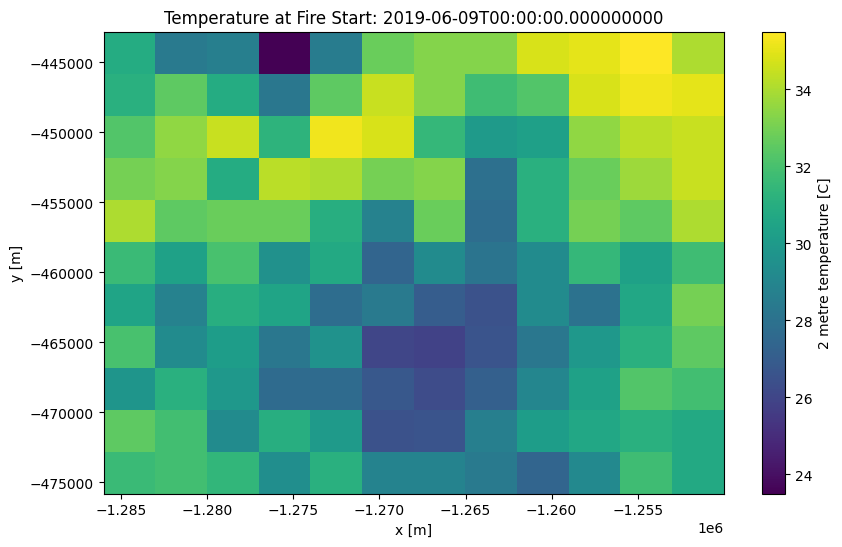

In [7]:
import matplotlib.pyplot as plt


# Draw a quick map
frame_0 = subset['temperature_2m'].isel(init_time=0, lead_time=0)
plt.figure(figsize=(10, 6))
frame_0.plot()
plt.title(f"Temperature at Fire Start: {t_start}")
plt.show()

New Shape: (1, 49)


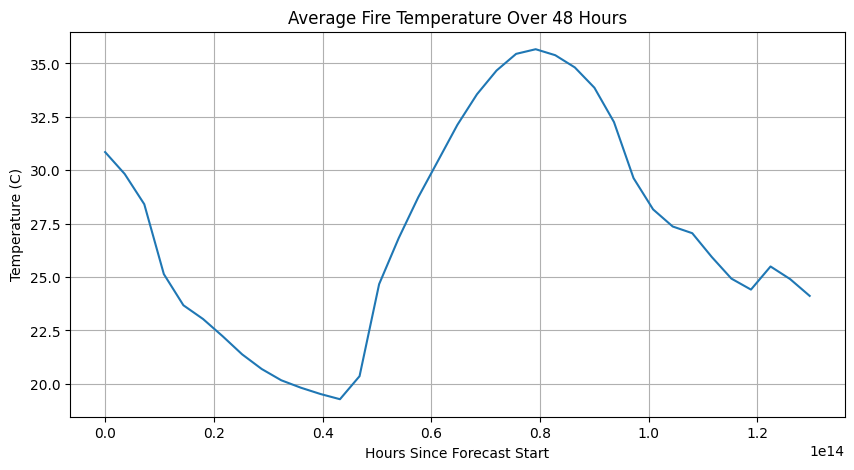

In [8]:
# Calculate the mean across the spatial dimensions (x and y)
daily_weather = subset.mean(dim=['x', 'y'])

print("New Shape:", daily_weather['temperature_2m'].shape)

# Now let's plot the timeline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# We plot the 'lead_time' (hours ahead) on the X-axis
daily_weather['temperature_2m'].isel(init_time=0).plot()
plt.title("Average Fire Temperature Over 48 Hours")
plt.xlabel("Hours Since Forecast Start")
plt.ylabel("Temperature (C)")
plt.grid(True)
plt.show()

In [ ]:
import xarray as xr
import pandas as pd
import os
import geopandas as gpd
import rioxarray  # Required for .rio.crs
from tqdm import tqdm # <--- Progress Bar Import
from joblib import Parallel, delayed
from shapely.ops import unary_union
from collections import Counter

# 1. SETUP
output_dir = Path("..") / "data" / "training_data"
os.makedirs(output_dir, exist_ok=True)
dataset_start = pd.to_datetime("2018-07-15")

# 2. AGGREGATION: THE UNION METHOD
# (Assuming df_flat is already loaded in your environment)
# If not, ensure you load your dataframe before this block.
print(f"Original Row Count: {len(df_flat)}")
df_flat['t'] = pd.to_datetime(df_flat['t'])

def combine_geoms(series):
    return unary_union(series)

print("Aggregating snapshots into unique Fire Events (Calculating Unions)...")
fire_events = df_flat.groupby('fireID').agg({
    't': ['min', 'max'],
    'hull': combine_geoms
}).reset_index()

fire_events.columns = ['fireID', 't_start', 't_end', 'geometry']

# Filter Post-2018
valid_fires = fire_events[fire_events['t_start'] >= dataset_start].copy()
global_crs = df_flat.crs 

print(f"Unique fires to download: {len(valid_fires)}")


# 3. CONNECT
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/hrrr/forecast-48-hour/latest.zarr?email=optional@email.com",
    decode_coords="all"
)

# 4. WORKER FUNCTION (With Smart Slicing)
def process_fire(row, weather_ds, output_folder, input_crs):
    try:
        fire_id = int(row['fireID'])
        t_start = row['t_start']
        t_end   = row['t_end']
        
        # Duration Check
        duration_days = (t_end - t_start).days
        if duration_days <= 0:
            t_end = t_start + pd.Timedelta(days=1)
            duration_days = 1
        
        if duration_days > 21:
            return "SKIPPED_TOO_LONG"

        # --- GEOMETRY TRANSFORMATION ---
        fire_gs = gpd.GeoSeries([row['geometry']], crs=input_crs)
        
        # Check for CRS in weather data
        if weather_ds.rio.crs is None:
             return "ERROR_NO_WEATHER_CRS"
             
        fire_proj = fire_gs.to_crs(weather_ds.rio.crs)
        min_x, min_y, max_x, max_y = fire_proj.total_bounds

        # --- SMART SLICING ---
        # 1. Try Standard Slice (Bottom-Up)
        subset = weather_ds.sel(
            x=slice(min_x, max_x),
            y=slice(min_y, max_y), 
            init_time=slice(t_start, t_end)
        )
        
        # 2. If Empty, Try Inverted Slice (Top-Down)
        # This handles grids where Y coordinates decrease from North to South
        if subset.sizes['y'] == 0:
             subset = weather_ds.sel(
                x=slice(min_x, max_x),
                y=slice(max_y, min_y), # <--- Swapped order
                init_time=slice(t_start, t_end)
            )

        # 3. Validation
        if subset.sizes['x'] == 0 or subset.sizes['y'] == 0:
            return "SKIPPED_OUT_OF_BOUNDS"
            
        if subset.sizes['init_time'] == 0:
            return "SKIPPED_NO_TIME_MATCH"

        # F. Download and Save
        subset.load()
        
        file_name = f"fireID_{fire_id}_weather.nc" 
        save_path = os.path.join(output_folder, file_name)
        subset.to_netcdf(save_path)
        
        return "SUCCESS"

    except Exception as e:
        return f"ERROR: {str(e)}"

# 5. EXECUTE
print(f"Starting parallel download...")

# The tqdm progress bar wraps the iterator here
results = Parallel(n_jobs=8, prefer="threads")(
    delayed(process_fire)(row, ds, output_dir, global_crs)
    for index, row in tqdm(valid_fires.iterrows(), total=len(valid_fires))
)

# UPDATED SUMMARY
print("-" * 30)
counts = Counter(results)
print("Detailed Results:")
for status, count in counts.items():
    print(f"{status}: {count}")

Original Row Count: 206232
Aggregating snapshots into unique Fire Events (Calculating Unions)...
